In [3]:
from glob import glob
from os import path
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import os
import numpy as np
import re
from os.path import basename, splitext

# from solver import Instance

from argparse import Namespace
import sys
sys.path.append('../solver')
# from solver_output import practice_print
from solver_rostering import run_roster_solver_objval, run_roster_solver_output

In [4]:
weekday_ = 'berlin_db=0.50_dt=doublepeak.json'
weekend_ = 'berlin_db=0.50_dt=uniform.json'

instance_file_weekday = f"../instances/{weekday_}"
instance_file_weekend = f"../instances/{weekend_}"

shift_file_weekday = f"../shifts/{weekday_}"
shift_file_weekend = f"../shifts/{weekend_}"

base_file = 'berlin_db=1.00'
model = "flex"
OC = 1.5
RM = 1.5
GM = 0.8
h_min = 32
h_max = 48
max_n_diff = 3
max_n_shifts = 3

workforce_dict = {0: 20, 1:20, 2:20, 3:20}

sol = run_roster_solver_output(model, instance_file_weekday, shift_file_weekday, 
                               instance_file_weekend, shift_file_weekend, workforce_dict, 
                               OC, RM, GM, h_min, h_max, max_n_diff)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 110800 rows, 166460 columns and 1399164 nonzeros
Model fingerprint: 0x9f001508
Variable types: 99120 continuous, 67340 integer (67340 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 106900 rows and 148498 columns
Presolve time: 4.99s
Presolved: 3900 rows, 17962 columns, 74762 nonzeros
Variable types: 1263 continuous, 16699 integer (16699 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1705750e+03   4.195000e+02   0.000000e+00      5s
   16727    2.8184000e+03   0.000000e+00   0.000000e+00      6s

Root relaxation: objective 2.818400e+03, 16727 iterations, 1.30 seconds (1.60 work units)

    Nodes    |    Curr

In [5]:
starts = []
# self.r[(employee, shift_start, day)]
for region in sol.i.regions:
    for employee in sol.i.employees[region]:
        for day in range(7):
            for shift_start in range(8):
                if (employee, shift_start, day) not in sol.r:
                    continue
                value = sol.r[(employee, shift_start, day)].X
                if value > 0.5:
                    starts.append({'employee': employee, 'shift_start': shift_start, 'shift_end': shift_start+4-1, 'day': day})

employee_starts_df = pd.DataFrame(starts)
employee_starts_df

,employee,shift_start,shift_end,day
0,0,2,5,0
1,0,2,5,1
2,0,2,5,2
3,0,2,5,3
4,0,4,7,5
...,...,...,...,...
392,79,4,7,1
393,79,2,5,3
394,79,4,7,4
395,79,0,3,5


In [6]:
employee_area_assignment = []
for day in sol.i.days:
    for region in sol.i.regions:
        for employee in sol.i.employees[region]:
            for area in sol.i.reg_areas[region]: 
                for theta in sol.i.periods[day]:
                    value = sol.k[(employee, area, theta, day)].X
                    if value > 0.5:
                        employee_area_assignment.append({'employee': employee, 'day': day, 'region': region, 'area': area, 'period': theta})
                   
employee_area_assignment_df = pd.DataFrame(employee_area_assignment).sort_values(['employee', 'day', 'period'])

In [7]:
# Validation check
employee_area_assignment_df.merge(employee_starts_df, on=['employee', 'day'], how='left').query('period < shift_start')
employee_area_assignment_df.merge(employee_starts_df, on=['employee', 'day'], how='left').query('period > shift_end')

,employee,day,region,area,period,shift_start,shift_end


In [8]:
# Employee
employee_area_assignment_df.query('employee == 0').groupby(['employee', 'day']).agg({'area': list, 'period': list})

area        period
employee day                                            
0        0    [10711, 10711, 10825, 10629]  [2, 3, 4, 5]
         1    [10719, 10707, 10585, 10719]  [2, 3, 4, 5]
         2    [10711, 10711, 10713, 10589]  [2, 3, 4, 5]
         3    [10715, 10629, 10553, 10553]  [2, 3, 4, 5]
         5    [10717, 10587, 10585, 10627]  [4, 5, 6, 7]
         6    [10555, 10555, 10585, 10777]  [0, 1, 2, 3]

In [9]:
employee_summary = (
    employee_area_assignment_df
    .groupby('employee')
    .agg({'day': ['nunique', 'count'], 'region':['nunique', 'unique']})
)
employee_summary.columns = ['n_days', 'periods_worked', 'n_region', 'region']

In [10]:
# Validation check
assert employee_summary.query('n_days > 6').shape[0] == 0
assert employee_summary.query('n_days < 4').shape[0] == 0

In [11]:
employee_summary.head(30)

,n_days,periods_worked,n_region,region
employee,,,,
0,6,24,1,[3]
1,6,24,1,[3]
2,6,24,1,[3]
3,6,24,1,[3]
4,6,24,1,[3]
5,6,24,1,[3]
6,6,24,1,[3]
7,6,24,1,[3]
8,6,24,1,[3]


# Summary results

In [30]:
# Costs
print('--- COSTS ---')
obj_val = sol.m.ObjVal
hiring_costs = 1 * sum( sol.r[(employee, shift_start, day)].X 
                   for region in sol.i.regions
                   for employee in sol.i.employees[region]
                   for day in sol.i.days
                   for shift_start in sol.i.shifts[(region, day)] )
outsourcing_costs = obj_val - hiring_costs
print(f'    Objective value: {obj_val} \n    Hiring costs: {hiring_costs} \n    Outsourcing costs: {outsourcing_costs}')

# Hours worked
print('--- HOURS WORKED ---')
people_hired = sum( 1
                   for region in sol.i.regions
                   for employee in sol.i.employees[region])

hours_worked_pct = sum(
    sol.k[(employee, area, theta, day)].X
    for day in sol.i.days
    for region in sol.i.regions
    for employee in sol.i.employees[region]
    for area in sol.i.reg_areas[region]
    for theta in sol.i.periods[day]
) / (people_hired * sol.i.h_max / 2) * 100 # hours per period 

print(f'    Overall hours worked pct: {hours_worked_pct}')

employee_hours = {}
for region in sol.i.regions:
    for employee in sol.i.employees[region]:
        employee_hours[employee] = sum(
            sol.k[(employee, area, theta, day)].X
            for day in sol.i.days
            for area in sol.i.reg_areas[region]
            for theta in sol.i.periods[day]
        ) / (sol.i.h_max / 2) * 100 # hours per period

print(f'    Mean hours pct per employee: {np.mean(list(employee_hours.values()))}')
print(f'    Std hours pct per employee: {np.std(list(employee_hours.values()))}')
print(f'    Quantile 25 hours pct per employee: {np.quantile(list(employee_hours.values()), 0.25)}')
print(f'    Median 25 hours pct per employee: {np.median(list(employee_hours.values()))}')
print(f'    Quantile 75 hours pct per employee: {np.quantile(list(employee_hours.values()), 0.75)}')

# Starting shifts 
print('--- SHIFTS STARTS ---')
employee_starts = []
# self.r[(employee, shift_start, day)]
for region in sol.i.regions:
    for employee in sol.i.employees[region]:
        for day in sol.i.days:
            for shift_start in sol.i.shifts[(region, day)]:
                value = sol.r[(employee, shift_start, day)].X
                if value > 0.5:
                    employee_starts.append({'employee': employee, 'shift_start': shift_start, 'day': day})

employee_starts_df = pd.DataFrame(employee_starts)
emp_ = employee_starts_df.groupby("employee").agg({"shift_start": "nunique"})["shift_start"]
print(f'    Mean shifts start: {emp_.mean()}')
print(f'    Quantile 25 shifts start: {emp_.quantile(0.25)}')
print(f'    Quantile 50 shifts start: {emp_.quantile(0.5)}')
print(f'    Quantile 75 shifts start: {emp_.quantile(0.75)}')

--- COSTS ---
    Objective value: 2830.7750000008114 
    Hiring costs: 397.0 
    Outsourcing costs: 2433.7750000008114
--- HOURS WORKED ---
    Overall hours worked pct: 82.70833333333333
    Mean hours pct per employee: 82.70833333333333
    Std hours pct per employee: 15.010123898370876
    Quantile 25 hours pct per employee: 66.66666666666666
    Median 25 hours pct per employee: 83.33333333333334
    Quantile 75 hours pct per employee: 100.0
--- SHIFTS STARTS ---
    Mean shifts start: 2.35
    Quantile 25 shifts start: 2.0
    Quantile 50 shifts start: 2.0
    Quantile 75 shifts start: 3.0


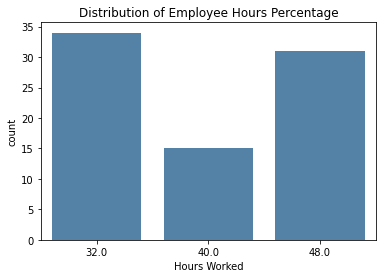

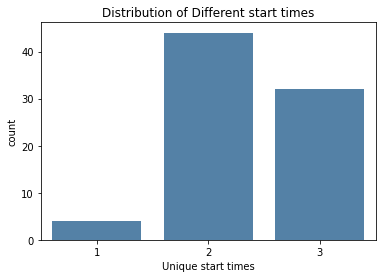

In [82]:
# PLOTS
employee_hours = {}
for region in sol.i.regions:
    for employee in sol.i.employees[region]:
        employee_hours[employee] = sum(
            sol.k[(employee, area, theta, day)].X * 2
            for day in sol.i.days
            for area in sol.i.reg_areas[region]
            for theta in sol.i.periods[day]
        )

sns.countplot(x=list(employee_hours.values()), color='steelblue')
# Adding title and x-axis label
plt.title('Distribution of Employee Hours Percentage')
plt.xlabel('Hours Worked')
plt.show()

unique_start_times = employee_starts_df.groupby("employee").agg({"shift_start": "nunique"})["shift_start"]
sns.countplot(x=unique_start_times, color='steelblue')
# Adding title and x-axis label
plt.title('Distribution of Different start times')
plt.xlabel('Unique start times')
#plt.xticks(np.arange(1, unique_start_times.max() + 1, step=1))
plt.show()

In [14]:
outsourced_parcels = dict()
outsourced_parcels_pct = dict()
inhouse_parcels = dict()

for region in sol.i.regions:
    for area in sol.i.reg_areas[region]:
        for day in sol.i.days:
            outsourced = list()
            outsourced_pct = list()
            inhouse = list()
            
            for theta in sol.i.periods:
                scenarios_with_demand = [scenario for scenario in sol.i.scenarios if sol.i.srequired[(scenario, area, theta, day)] > 0]

                if len(scenarios_with_demand) == 0:
                    outsourced.append(0)
                    outsourced_pct.append(0)
                    inhouse.append(0)
                    continue
                
                tot_outsourced = sum(
                    (sol.i.srequired[(s, area, theta, day)] - 
                        sum( sol.k[(employee, area, theta, day)].X for employee in sol.i.employees[region] )
                    ) * sol.i.sdemand[(s, area, theta, day)] / sol.i.srequired[(s, area, theta, day)] \
                    for s in scenarios_with_demand
                )
                tot_outsourced_pct = sum(
                    100 * (sol.i.srequired[(s, area, theta, day)] - 
                        sum( sol.k[(employee, area, theta, day)].X for employee in sol.i.employees[region] )
                    ) / sol.i.srequired[(s, area, theta, day)] \
                    for s in scenarios_with_demand
                )
                tot_inhouse = sum(
                    sol.i.sdemand[(s, area, theta, day)] *  sum( sol.k[(employee, area, theta, day)].X for employee in sol.i.employees[region] ) / sol.i.srequired[(s, area, theta, day)] \
                    for s in scenarios_with_demand
                )

                # If we hire more couriers than we need, we don't outsource a negative amount,
                # we outsource zero.
                tot_outsourced = max(tot_outsourced, 0)
                tot_outsourced_pct = max(tot_outsourced_pct, 0)

                avg_outsourced = tot_outsourced / len(scenarios_with_demand)
                avg_outsourced_pct = tot_outsourced_pct / len(scenarios_with_demand)
                avg_inhouse = tot_inhouse / len(scenarios_with_demand)

                outsourced.append(avg_outsourced)
                outsourced_pct.append(avg_outsourced_pct)
                inhouse.append(avg_inhouse)

            outsourced_parcels[(area, day)] = outsourced
            outsourced_parcels_pct[(area, day)] = outsourced_pct
            inhouse_parcels[(area, day)] = inhouse

In [47]:
# Outsourcing
print('--- OUTSOURCING ---')

outsourcing_parcels_df = (
    pd.DataFrame.from_dict(outsourced_parcels_pct, orient='index')
    .reset_index()
)
outsourcing_parcels_df = outsourcing_parcels_df.assign(
    area = outsourcing_parcels_df['index'].apply(lambda x: x[0]),
    day = outsourcing_parcels_df['index'].apply(lambda x: x[1]),
    area_mean_pct = outsourcing_parcels_df[[0, 1, 2, 3, 4, 5, 6]].mean(axis=1),
)
print(f'    Mean Outsourcing Percentage: {outsourcing_parcels_df["area_mean_pct"].mean()}')
print(f'    Std Outsourcing Percentage: {outsourcing_parcels_df["area_mean_pct"].std()}')
print(f'    Quantile 25 Outsourcing Percentage: {outsourcing_parcels_df["area_mean_pct"].quantile(0.25)}')
print(f'    Quantile 50 Outsourcing Percentage: {outsourcing_parcels_df["area_mean_pct"].quantile(0.50)}')
print(f'    Quantile 75 Outsourcing Percentage: {outsourcing_parcels_df["area_mean_pct"].quantile(0.75)}')


--- OUTSOURCING ---
    Mean Outsourcing Percentage: 40.90671377509841
    Std Outsourcing Percentage: 22.98038436881937
    Quantile 25 Outsourcing Percentage: 28.571428571428573
    Quantile 50 Outsourcing Percentage: 42.857142857142854
    Quantile 75 Outsourcing Percentage: 43.877551020408156


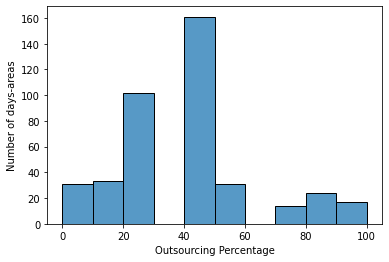

In [75]:
sns.histplot(data=outsourcing_parcels_df, x='area_mean_pct', bins=10)
# Adding title and x-axis label
plt.title('')
plt.xlabel('Outsourcing Percentage')
plt.ylabel('Number of days-areas')
plt.show()